In [1]:
# nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import multiprocessing
import time
import warnings

from tqdm import tqdm
from torch import nn
from torch_scatter import scatter
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCNConv, global_mean_pool
from torch_geometric.utils import add_self_loops, degree
from utils.preprocessing_for_contour import create_data

In [3]:
# load image file paths
svg_folder = './datasets/svg'
png_folder = './datasets/png'
imgs = []
png = []
dataset = []

for root, folders, files in os.walk(svg_folder):
    for file in files:
        if file.split('.')[1] != 'svg': continue
        if 'checkpoint' in file: continue
        
        file_path = os.path.join(svg_folder, file)
        imgs.append(file_path)
        
        file_path = os.path.join(png_folder, file.replace('svg', 'png'))
        png.append(file_path)

In [26]:
 # warnings.filterwarnings("ignore")
# for i, file_path in enumerate(tqdm(imgs)):
#     # try:
#     #     dataset.append(create_data(file_path))
#     # except:
#     #     print(file_path)
#     #     raise SystemExit
        
#     file_path = "./datasets/svg/032-firewood.svg"
#     file_path = "./datasets/svg/011-library.svg"
#     data = create_data(file_path)
#     print(data)
#     break

  0%|          | 0/2000 [00:00<?, ?it/s]

Data(x=[80, 2], edge_index=[2, 160], edge_attr=[160, 4], rgb=[6, 3], hsv=[6, 3], cluster=[80], group_edge_index=[2, 14], group_edge_attr=[14])


In [5]:
imgs = imgs[:2000]
warnings.filterwarnings("ignore")
dataset = []
for data in tqdm(multiprocessing.Pool(8).imap_unordered(create_data, imgs), total=len(imgs)):
    dataset.append(data)

100%|██████████| 2000/2000 [00:14<00:00, 140.05it/s]


In [6]:
# hyperparameters
torch.manual_seed(16)

batch_size = 1
num_epoch = 50

_train = int(len(dataset) * 0.9)
_val = _train + int(len(dataset) * 0.05)
_test = len(dataset) - _val

# create dataloader
train_set, val_set, test_set = dataset[:_train], dataset[_train:_val], dataset[_val:]
train_svg, val_svg, test_svg = imgs[:_train], imgs[_train:_val], imgs[_val:]
train_png, val_png, test_png = png[:_train], png[_train:_val], png[_val:]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Training Data: {len(train_set)}\nValidation Data: {len(val_set)}\nTesting Data: {len(test_set)}")

Training Data: 1800
Validation Data: 100
Testing Data: 100


In [7]:
class GraphEncoder(nn.Module):
    def __init__(self):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(2, 16, improved=True)
        self.conv2 = GCNConv(16, 64, improved=True)
        
    def forward(self, x, edge_index, cluster):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = scatter(x, cluster, dim=0, reduce='mean')
        return x

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.layers(x)
    
# class SVGConv(MessagePassing):
#     def __init__(self,
#                  in_channels: int,
#                  out_channels: int,
#                  improved: bool = True,
#                  add_self_loops: bool = True,
#                  normalize: bool = True,
#                  bias: bool = True,
#                  **kwargs
#     ):
#         super(SVGConv, self).__init__(aggr="mean", **kwargs)
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.improved = improved
#         self.add_self_loops = add_self_loops
#         self.normalize = normalize
        
#         self.lin = nn.Linear(in_channels, out_channels, bias=False)
        
#         if bias:
#             self.bias = nn.Parameter(torch.Tensor(out_channels))
#         else:
#             self.register_parameter("bias", None)
        
#         self.reset_parameters()
        
#     def reset_parameters(self):
#         torch.nn.init.uniform_(self.lin.weight)
#         if self.bias is not None:
#             torch.nn.init.normal_(self.bias, mean=0.0, std=0.1)
        
#     def forward(self, x, edge_index, edge_attr):
#         out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
#         return out
    
#     def message(self, x_i, x_j, edge_attr):
#         if edge_attr == 2:  # overlap
            
#         elif edge_attr == 3:  # contain
#         else:  # adjacent
            
#         return super().message(x_j)
    
class GraphNet(nn.Module):
    def __init__(self):
        super(GraphNet, self).__init__()
        self.encode = GraphEncoder()
        self.gcn1 = GCNConv(64, 128)
        self.gcn2 = GCNConv(128, 64)
        # self.gcn1 = SVGConv(64, 128)
        # self.gcn2 = SVGConv(128, 64)
        self.fc = MLP()
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        cluster = data.cluster.type(torch.long)
        group_edge_index, group_edge_attr = data.group_edge_index, data.group_edge_attr
        
        out = self.encode(x, edge_index, cluster)
        
        if len(group_edge_attr) != 0:
            out = self.gcn1(out, group_edge_index, group_edge_attr)
            out = F.relu(out)
            out = self.gcn2(out, group_edge_index, group_edge_attr)
            out = F.relu(out)
        out = self.fc(out)
        
        return out

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
criterion = torch.nn.MSELoss(reduction='mean')

In [16]:
# training
train_losses = []
val_losses = []
best_loss = float('inf')
train_err = 0
val_err = 0

for epoch in range(num_epoch):  # num_epoch
    train_loss = 0
    val_loss = 0
    
    model.train()
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device)
        if data.x.shape[0] == 0:
            train_err += 1
            continue
        
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.rgb)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        if data.x.shape[0] == 0:
            val_err += 1
            continue
        out = model(data)
        loss = criterion(out, data.rgb)
        
        val_loss += loss.item()
    
    train_avg = train_loss / (len(train_loader)-train_err)
    val_avg = val_loss / (len(val_loader)-val_err)
    train_losses.append(loss.item())
    val_losses.append(loss.item())
    
    print(f'Epoch {epoch}\tTraining Loss: {train_avg}\tValidation Loss: {val_avg}')
    
    if val_avg < best_loss:
        print(f'Validation Loss Decreased({best_loss:.6f}--->{val_avg:.6f})\tSaving The Model')
        best_loss = val_avg
        torch.save(model.state_dict(), 'best_checkpoint.pth')

100%|██████████| 100/100 [00:00<00:00, 327.24it/s]


Epoch 0	Training Loss: 0.21908813660328927	Validation Loss: 0.2074651014432311
Validation Loss Decreased(inf--->0.207465)	Saving The Model


100%|██████████| 100/100 [00:00<00:00, 327.29it/s]


Epoch 1	Training Loss: 0.21794806705844222	Validation Loss: 0.20710397952236234
Validation Loss Decreased(0.207465--->0.207104)	Saving The Model


100%|██████████| 100/100 [00:00<00:00, 319.00it/s]


Epoch 2	Training Loss: 0.1340246946601858	Validation Loss: 0.11608774565160275
Validation Loss Decreased(0.207104--->0.116088)	Saving The Model


100%|██████████| 100/100 [00:00<00:00, 326.78it/s]


Epoch 3	Training Loss: 0.11406483791943833	Validation Loss: 0.11492182292044163
Validation Loss Decreased(0.116088--->0.114922)	Saving The Model


100%|██████████| 100/100 [00:00<00:00, 325.13it/s]


Epoch 4	Training Loss: 0.11467632226210799	Validation Loss: 0.11578979182988405


100%|██████████| 100/100 [00:00<00:00, 322.67it/s]


Epoch 5	Training Loss: 0.11538117591191387	Validation Loss: 0.1158485585078597


100%|██████████| 100/100 [00:00<00:00, 319.40it/s]


Epoch 6	Training Loss: 0.11607216953588934	Validation Loss: 0.1161155380308628


100%|██████████| 100/100 [00:00<00:00, 325.39it/s]


Epoch 7	Training Loss: 0.11659381160710904	Validation Loss: 0.11564294811338187


100%|██████████| 100/100 [00:00<00:00, 307.73it/s]


Epoch 8	Training Loss: 0.11710465306100837	Validation Loss: 0.1169889622554183


100%|██████████| 100/100 [00:00<00:00, 324.01it/s]


Epoch 9	Training Loss: 0.11773798781670412	Validation Loss: 0.11662611588835717


100%|██████████| 100/100 [00:00<00:00, 261.11it/s]


Epoch 10	Training Loss: 0.11836864094554869	Validation Loss: 0.11577514581382274


100%|██████████| 100/100 [00:00<00:00, 209.13it/s]


Epoch 11	Training Loss: 0.11896251568991259	Validation Loss: 0.11563869953155517


100%|██████████| 100/100 [00:00<00:00, 178.58it/s]


Epoch 12	Training Loss: 0.11948205738600103	Validation Loss: 0.11651547826826572


100%|██████████| 100/100 [00:00<00:00, 205.30it/s]


Epoch 13	Training Loss: 0.1201743841184617	Validation Loss: 0.11641835115849972


100%|██████████| 100/100 [00:00<00:00, 195.50it/s]


Epoch 14	Training Loss: 0.12082869641695385	Validation Loss: 0.11626380812376738


100%|██████████| 100/100 [00:00<00:00, 213.73it/s]


Epoch 15	Training Loss: 0.1215116311211121	Validation Loss: 0.1163441901281476


100%|██████████| 100/100 [00:00<00:00, 209.35it/s]


Epoch 16	Training Loss: 0.12215151343128232	Validation Loss: 0.11683944229036569


100%|██████████| 100/100 [00:00<00:00, 212.56it/s]


Epoch 17	Training Loss: 0.12277242966378346	Validation Loss: 0.11583671782165766


100%|██████████| 100/100 [00:00<00:00, 194.58it/s]


Epoch 18	Training Loss: 0.12342689751702869	Validation Loss: 0.1158721387758851


100%|██████████| 100/100 [00:00<00:00, 206.37it/s]


Epoch 19	Training Loss: 0.12404743085017451	Validation Loss: 0.11585091944783926


100%|██████████| 100/100 [00:00<00:00, 202.20it/s]


Epoch 20	Training Loss: 0.12486109477227923	Validation Loss: 0.11588472843170167


100%|██████████| 100/100 [00:00<00:00, 214.87it/s]


Epoch 21	Training Loss: 0.12547761035534308	Validation Loss: 0.11581592939794064


100%|██████████| 100/100 [00:00<00:00, 216.42it/s]


Epoch 22	Training Loss: 0.12621946530609537	Validation Loss: 0.11600786581635475


100%|██████████| 100/100 [00:00<00:00, 215.88it/s]


Epoch 23	Training Loss: 0.12685723418329908	Validation Loss: 0.1170848647877574


100%|██████████| 100/100 [00:00<00:00, 216.18it/s]


Epoch 24	Training Loss: 0.12767602525769717	Validation Loss: 0.11575767926871777


100%|██████████| 100/100 [00:00<00:00, 213.30it/s]


Epoch 25	Training Loss: 0.12832486407776597	Validation Loss: 0.11655629131942988


100%|██████████| 100/100 [00:00<00:00, 326.97it/s]


Epoch 26	Training Loss: 0.12915541193051433	Validation Loss: 0.11615986000746488


100%|██████████| 100/100 [00:00<00:00, 293.98it/s]


Epoch 27	Training Loss: 0.12970034200072442	Validation Loss: 0.11641323160380125


100%|██████████| 100/100 [00:00<00:00, 311.95it/s]


Epoch 28	Training Loss: 0.1305885613848146	Validation Loss: 0.11560051456093788


100%|██████████| 100/100 [00:00<00:00, 319.03it/s]


Epoch 29	Training Loss: 0.13133547449289681	Validation Loss: 0.1165170618146658


100%|██████████| 100/100 [00:00<00:00, 319.55it/s]


Epoch 30	Training Loss: 0.1321332342102193	Validation Loss: 0.11536914370954036


100%|██████████| 100/100 [00:00<00:00, 329.08it/s]


Epoch 31	Training Loss: 0.13286780186672573	Validation Loss: 0.11584366597235203


100%|██████████| 100/100 [00:00<00:00, 314.07it/s]


Epoch 32	Training Loss: 0.1335849335054041	Validation Loss: 0.11588639099150896


100%|██████████| 100/100 [00:00<00:00, 291.67it/s]


Epoch 33	Training Loss: 0.13443289171103912	Validation Loss: 0.11647494100034236


100%|██████████| 100/100 [00:00<00:00, 292.63it/s]


Epoch 34	Training Loss: 0.1352698660364707	Validation Loss: 0.11554905541241169


100%|██████████| 100/100 [00:00<00:00, 298.63it/s]


Epoch 35	Training Loss: 0.13608817630169817	Validation Loss: 0.11572205986827612


100%|██████████| 100/100 [00:00<00:00, 307.48it/s]


Epoch 36	Training Loss: 0.13684618589039776	Validation Loss: 0.1159742421284318


100%|██████████| 100/100 [00:00<00:00, 290.86it/s]


Epoch 37	Training Loss: 0.13802093907996543	Validation Loss: 0.11571072623133659


100%|██████████| 100/100 [00:00<00:00, 303.13it/s]


Epoch 38	Training Loss: 0.13867322430708764	Validation Loss: 0.11578535106033087


100%|██████████| 100/100 [00:00<00:00, 303.63it/s]


Epoch 39	Training Loss: 0.13938842846934374	Validation Loss: 0.11554174952208995


100%|██████████| 100/100 [00:00<00:00, 304.66it/s]


Epoch 40	Training Loss: 0.14039075919208954	Validation Loss: 0.11631999328732491


100%|██████████| 100/100 [00:00<00:00, 313.35it/s]


Epoch 41	Training Loss: 0.1412053052971268	Validation Loss: 0.11601909767836333


100%|██████████| 100/100 [00:00<00:00, 313.15it/s]


Epoch 42	Training Loss: 0.14214557897752997	Validation Loss: 0.11646632716059685


100%|██████████| 100/100 [00:00<00:00, 315.79it/s]


Epoch 43	Training Loss: 0.14314268202191893	Validation Loss: 0.11559419993311167


100%|██████████| 100/100 [00:00<00:00, 309.28it/s]


Epoch 44	Training Loss: 0.1440621757913234	Validation Loss: 0.11516727909445762


100%|██████████| 100/100 [00:00<00:00, 304.55it/s]


Epoch 45	Training Loss: 0.14494736810197348	Validation Loss: 0.11553401231765748


100%|██████████| 100/100 [00:00<00:00, 318.52it/s]


Epoch 46	Training Loss: 0.1458358307705195	Validation Loss: 0.11640935707837344


100%|██████████| 100/100 [00:00<00:00, 314.34it/s]


Epoch 47	Training Loss: 0.1468352871390103	Validation Loss: 0.11604966919869185


100%|██████████| 100/100 [00:00<00:00, 318.17it/s]


Epoch 48	Training Loss: 0.1478366894459707	Validation Loss: 0.11591350831091404


100%|██████████| 100/100 [00:00<00:00, 299.40it/s]

Epoch 49	Training Loss: 0.14873981464447247	Validation Loss: 0.11613663699477911


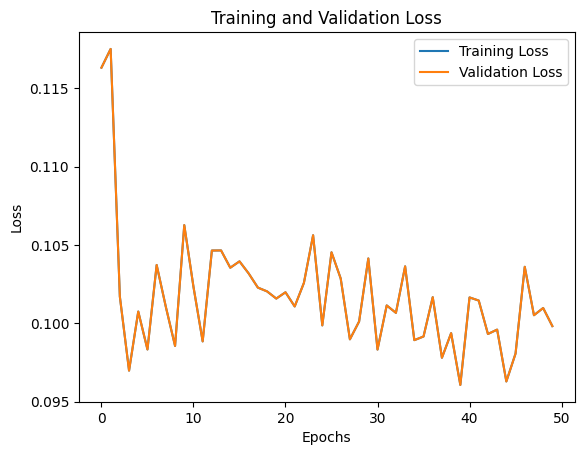

In [17]:
# plot losses
import matplotlib.pyplot as plt

_x = list(range(num_epoch))  # num_epoch
plt.plot(_x, train_losses, label='Training Loss')
plt.plot(_x, val_losses, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# testing
model.load_state_dict(torch.load('./best_checkpoint.pth'))
model.eval()

test_loss = 0
test_err = 0
for i, data in enumerate(tqdm(test_loader)):
    data = data.to(device)
    if data.x.shape[0] == 0:
        test_err += 1
        continue
    out = model(data)
    loss = criterion(out, data.rgb)
    test_loss += loss.item()
    
print(f'Testing Loss: {test_loss / (len(test_loader)-test_err)}')

100%|██████████| 100/100 [00:00<00:00, 310.88it/s]

Testing Loss: 0.11149549558758735


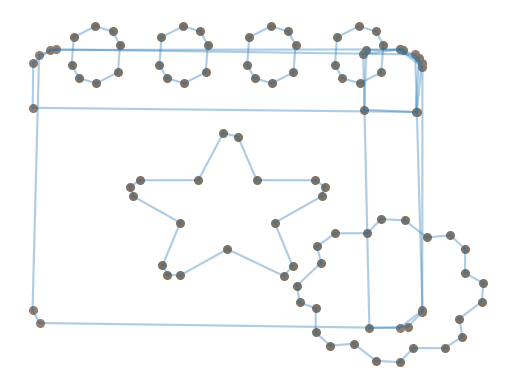

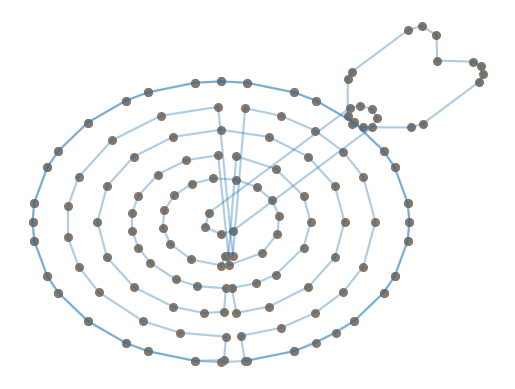

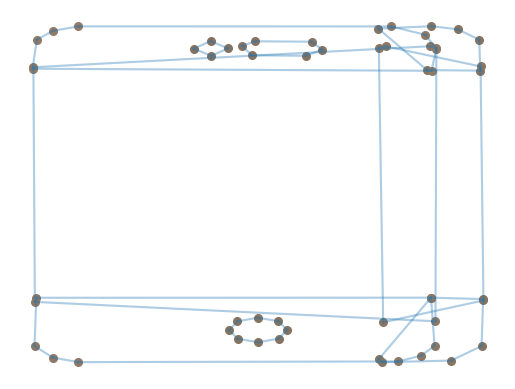

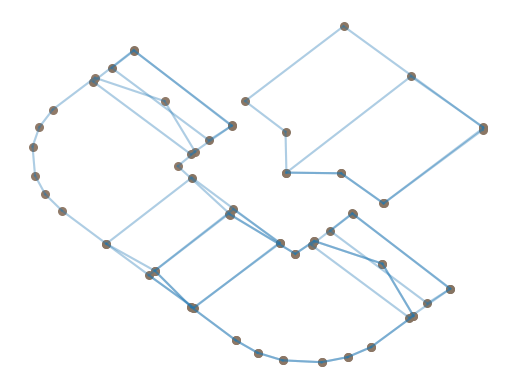

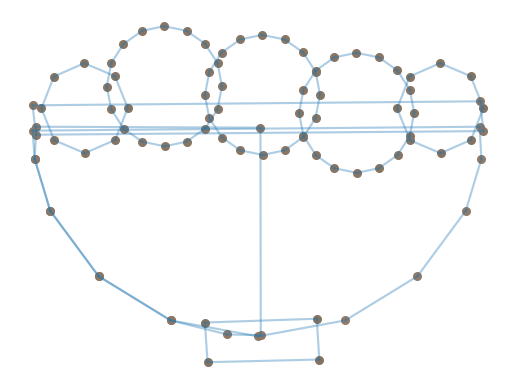

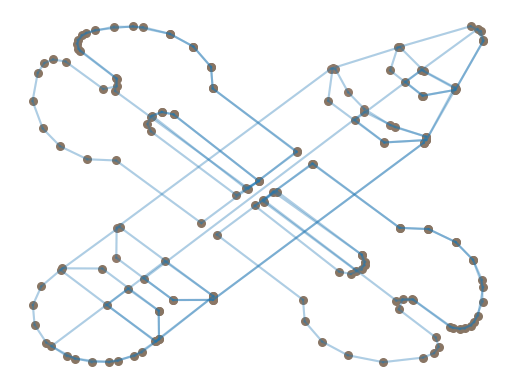

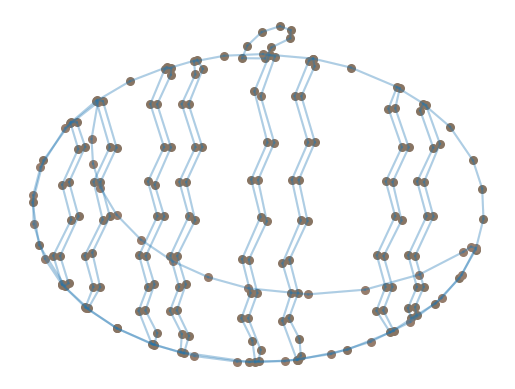

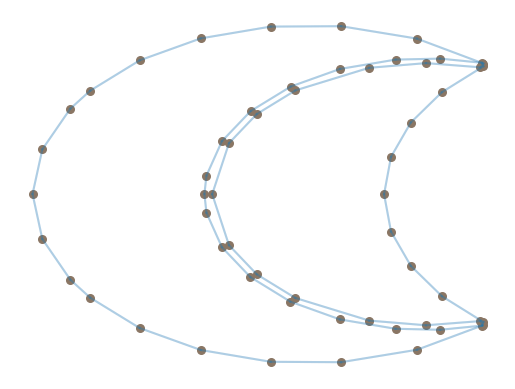

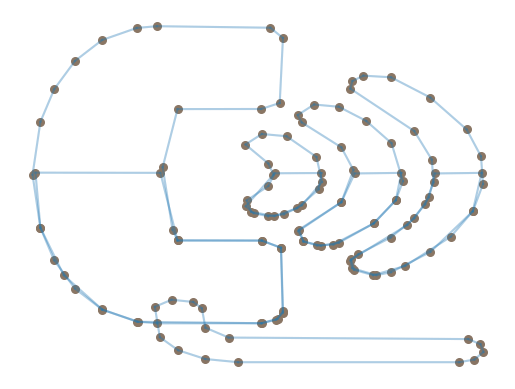

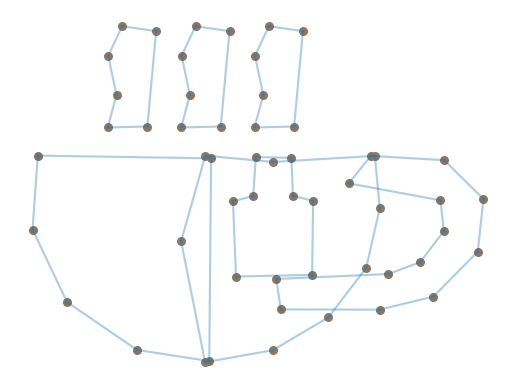

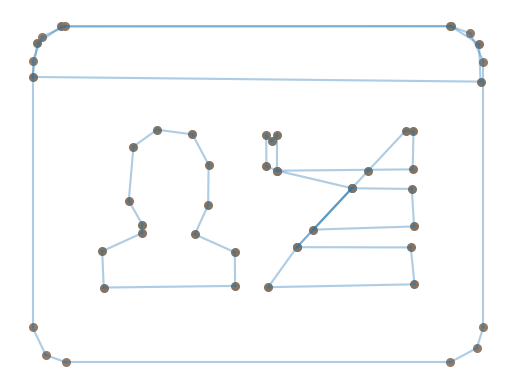

In [24]:
# visualize testing results
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

vis_loader = DataLoader(test_set, batch_size=1, shuffle=False)
model.load_state_dict(torch.load('./best_checkpoint.pth'))
model.eval()

idx = 0

for data, png in zip(vis_loader, test_png):
    fig = plt.figure("plot")
    ax = fig.add_subplot(1, 1, 1)
    plt.axis("off")
    
    data = data.to(device)
    out = model(data)
    
    pos = data.x.cpu().detach().numpy()
    rgb = out.cpu().detach().numpy()
    # rgb = data.rgb.cpu().detach().numpy()
    edge = np.transpose(data.edge_index.cpu().detach().numpy())
    cluster = data.cluster.cpu().detach().numpy()

    for n1, n2 in edge:
        x1, y1 = pos[n1]
        x2, y2 = pos[n2]
        l = Line2D([x1,x2], [y1,y2], alpha=0.2)
        ax.add_line(l)
    
    for (x, y), clu in zip(pos, cluster):
        plt.scatter(x, y, color=rgb[int(clu)], s=30)
        
    plt.axis("off")
    plt.show()
    plt.close()
    
    idx += 1
    if idx > 10: break